### 1. Initial Libraries and config

In [1]:
import random, logging
from types import SimpleNamespace

import torch, wandb
from fastprogress import progress_bar

from cloud_diffusion.dataset import download_dataset, CloudDataset
from cloud_diffusion.ddpm import ddim_sampler
from cloud_diffusion.models import UNet2D, get_unet_params
from cloud_diffusion.utils import parse_args, set_seed
from cloud_diffusion.wandb import to_video, vhtile

logging.basicConfig(format='%(asctime)s - %(levelname)s: %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

PROJECT_NAME = "ddpm_clouds"
DATASET_ARTIFACT = 'capecape/gtc/np_dataset:v1'
JOB_TYPE = "inference"
MODEL_ARTIFACT = "capecape/ddpm_clouds/esezp3jh_unet_small:v0"  # small model

config = SimpleNamespace(
    model_name="unet_small", # model name to save [unet_small, unet_big]
    sampler_steps=333, # number of sampler steps on the diffusion process
    num_frames=4, # number of frames to use as input,
    img_size=64, # image size to use
    num_random_experiments = 2, # we will perform inference multiple times on the same inputs
    seed=42,
    device="cuda" if torch.cuda.is_available() else "cpu",
    # device="mps",
    sampler="ddim",
    future_frames=10,  # number of future frames
    bs=8, # how many samples
)


C:\Users\wangt\AppData\Local\anaconda3\envs\clouddiff\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Inference Class

In [ ]:
class Inference:

### 2.1 Initial function parepare:
- config
- data
- DDIM
- params for model
- load model
- run the model

In [ ]:
    def __init__(self, config):
            # load config
            self.config = config
            set_seed(config.seed)

            # create a batch of data to use for inference
            self.prepare_data()

            # we default to ddim as it's faster and as good as ddpm
            self.sampler = ddim_sampler(config.sampler_steps)

            # create the Unet
            model_params = get_unet_params(config.model_name, config.num_frames)

            logger.info(f"Loading model {config.model_name} from artifact: {MODEL_ARTIFACT}")
            self.model = UNet2D.from_artifact(model_params, MODEL_ARTIFACT).to(config.device)

            self.model.eval()

### 2.2 Load dataset and assemble batch

In [ ]:
    def prepare_data(self):
        "Generates a batch of data from the validation dataset"
        logger.info(f"Downloading dataset from artifact: {DATASET_ARTIFACT}")
        files = download_dataset(DATASET_ARTIFACT, PROJECT_NAME)

        self.valid_ds = CloudDataset(files=files[-3:], # 3 days of validation data 
                                num_frames=config.num_frames, img_size=config.img_size)
        self.idxs = random.choices(range(len(self.valid_ds) - config.future_frames), k=config.bs)  # select some samples
        # fix the batch to the same samples for reproducibility
        self.batch = self.valid_ds[self.idxs].to(config.device)

### 2.3 Generate n forecasted frames
- n is from config: num_random_experiments = 2
- #### call function  self.sample_more to generate new frame

In [ ]:
    def forecast(self):
            "Perform inference on the batch of data."
            logger.info(f"Forecasting {self.batch.shape[0]} samples for {self.config.future_frames} future frames.")
            sequences = []
            for i in range(self.config.num_random_experiments):
                print('forecasting: ' + str(i))
                logger.info(f"Generating {i+1}/{self.config.num_random_experiments} futures.")
                frames = self.sample_more(self.batch, self.config.future_frames)
                sequences.append(frames)

            return sequences

### 2.4 Core function to Generate name frame
- #### using 3 frames to generate it
- #### use DDIM sampler ro generate forecast
    - #### we default to ddim as it's faster and as good as ddpm
    - `self.sampler = ddim_sampler(config.sampler_steps)`
- add frames to sequence
- #### convert data from GPU to CPU before return it `frames.cpu()`

### new_frame is saved as npy data, see section 4.1

In [ ]:
    def sample_more(self, frames, future_frames=1):
            "Autoregressive sampling, starting from `frames`. It is hardcoded to work with 3 frame inputs."
            for _ in progress_bar(range(future_frames), total=future_frames, leave=True):
                # compute new frame with previous 3 frames
                new_frame = self.sampler(self.model, frames[:,-3:,...])
                #tommy: save to local array
                fn = r'D:\Tommy\cloud_diffusion\out\\'+ str(cc)+ '.npy'
                np.save(fn,new_frame)
                # add new frame to the sequence
                frames = torch.cat([frames, new_frame.to(frames.device)], dim=1)
            return frames.cpu()


### 2.5 Log to WANDB site
- extra functions are defined at wandb.py in util folder

In [2]:
    def log_to_wandb(self, sequences):
        "Create a table with the ground truth and the generated frames. Log it to wandb."
        table = wandb.Table(columns=["id", "gt", *[f"gen_{i}" for i in range(config.num_random_experiments)], "gt/gen"])
        for i, idx in enumerate(self.idxs):
            gt_vid = to_video(self.valid_ds[idx:idx+4+config.future_frames,0,...])
            pred_vids = [to_video(frames[i]) for frames in sequences]
            gt_gen = wandb.Image(vhtile(self.valid_ds[idx:idx+4+config.future_frames,0,...], *[frames[i] for frames in sequences]))
            table.add_data(idx, gt_vid, *pred_vids, gt_gen)
        logger.info("Logging results to wandb...")
        wandb.log({f"gen_table_{config.future_frames}_random":table})

### 3. Main code

In [ ]:
parse_args(config)
    set_seed(config.seed)

    with wandb.init(project=PROJECT_NAME, job_type=JOB_TYPE, 
                    config=config, tags=["ddpm", config.model_name]):
        infer = Inference(config)
        sequences = infer.forecast()
        infer.log_to_wandb(sequences)

### 4. Images analysis

In [14]:
import numpy as np
import matplotlib.pyplot as plt

### 4.1 new_frame
- config.bs=8
- 8 images in one frame
- they are different
- image size is 64x64

In [6]:
new_frame= np.load(r'D:\Tommy\cloud_diffusion\out\1\0.npy')

In [7]:
print(new_frame.shape)

(8, 1, 64, 64)


In [27]:
def plot_frames(f,n):
    # Defining number of rows and columns
    fig = plt.figure(figsize=(14, 4))
    rows = 1
    cols = n

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < n:
                plt.imshow(f[idx,0,:,:], cmap="gray")
                idx += 1
    #fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

### Every column has sequenced images

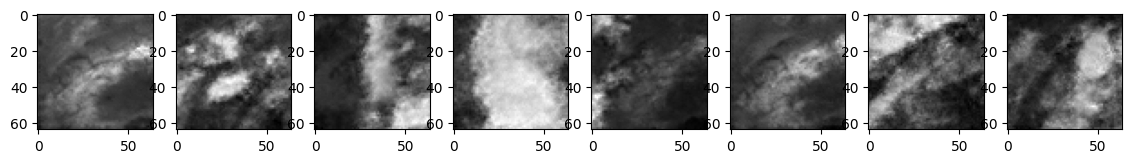

In [28]:
plot_frames(np.load(r'D:\Tommy\cloud_diffusion\out\1\0.npy'),8)

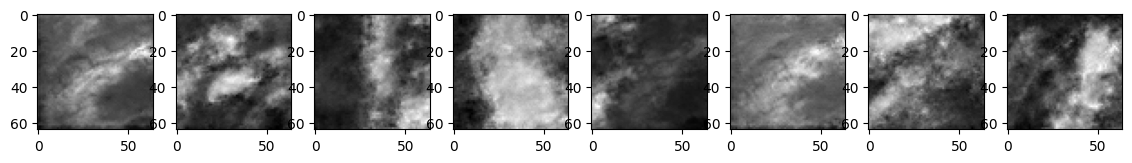

In [20]:
plot_frames(np.load(r'D:\Tommy\cloud_diffusion\out\1\1.npy'),8)

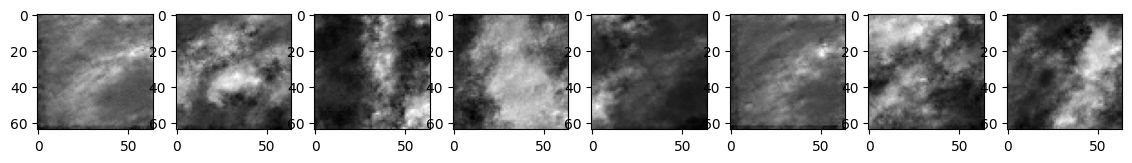

In [21]:
plot_frames(np.load(r'D:\Tommy\cloud_diffusion\out\1\2.npy'),8)

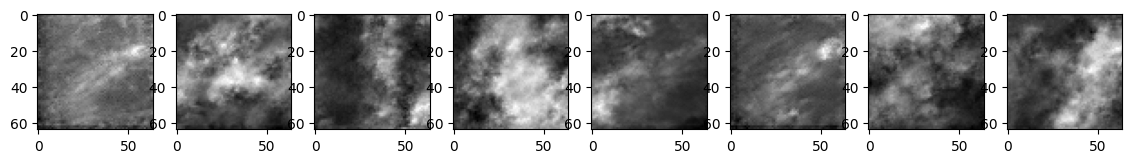

In [22]:
plot_frames(np.load(r'D:\Tommy\cloud_diffusion\out\1\3.npy'),8)

### 4.2 All Frames
- 8 samples in a row, one row has 4 images

- fo = r'D:\Tommy\cloud_diffusion\out\original3frames_'+ str(cc)+ '.npy'
- all_frames = frames.cpu()
- np.save(fo,all_frames)

In [24]:
o_frames = np.load(r'D:\Tommy\cloud_diffusion\out\1\original3fraes_0.npy')

In [25]:
o_frames.shape

(8, 4, 64, 64)

### Plot one set together (3 Previous and 1 predicted)
- 8 samples and 4 frames per example

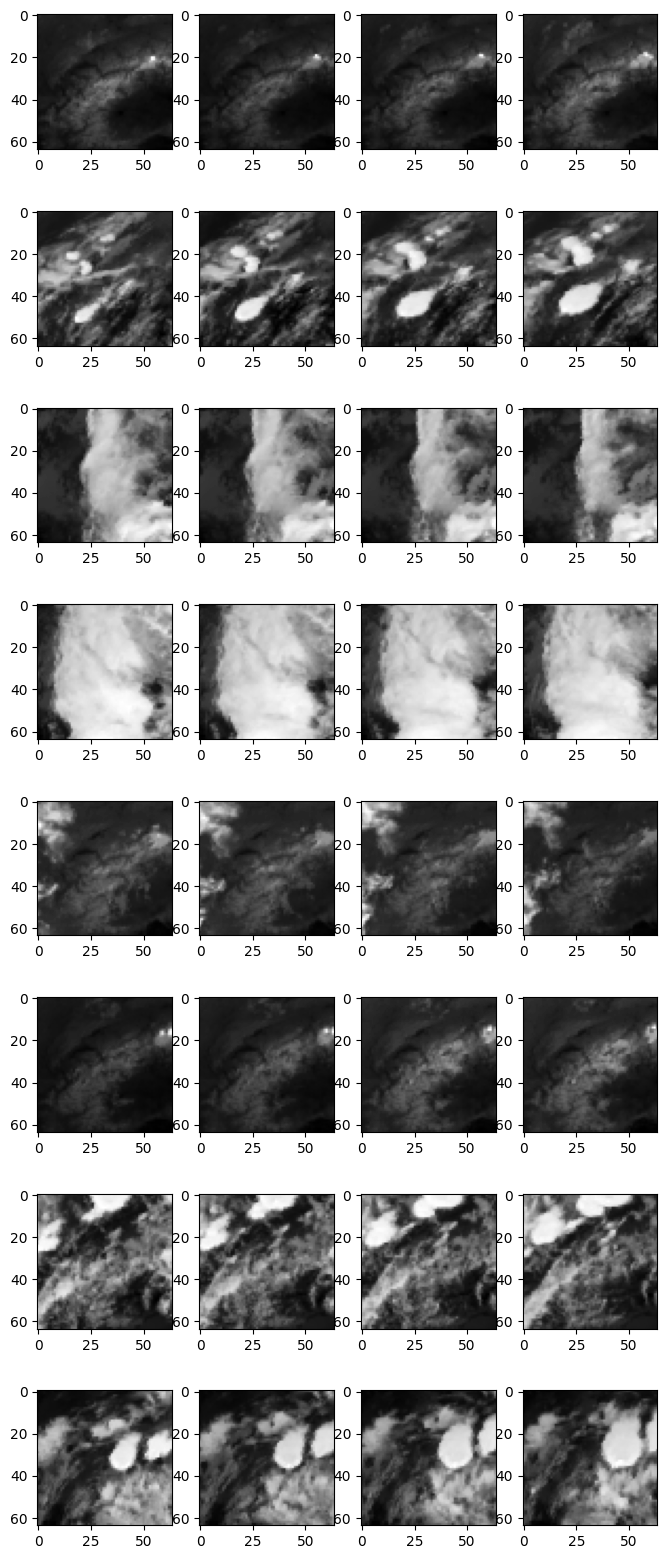

In [32]:
fig = plt.figure(figsize=(8, 20))
rows = 8
cols = 4
# Populating figure with sub-plots
idx = 0
for r in range(rows):
    for c in range(cols):
        fig.add_subplot(rows, cols, idx + 1)
        plt.imshow(o_frames[r,c,:,:], cmap="gray")
        idx += 1
# Showing the figure
plt.show()